In [10]:
import scipy.io as sio 
import numpy as np
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt 
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D
import re

import imageio,os

mat = sio.loadmat('data/swiss_roll_data.mat')

## View the data of swiss roll

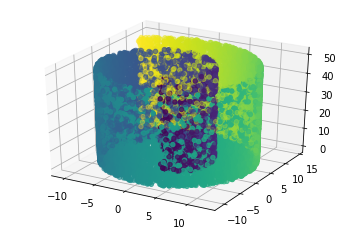

In [2]:

fig =plt.figure()
ax = fig.add_subplot(111,projection = '3d')
ax.scatter(mat['X_data'].T[:,0],mat['X_data'].T[:,1],mat['X_data'].T[:,2],c = mat['Y_data'][0])

## Igorne the 3rd dimension

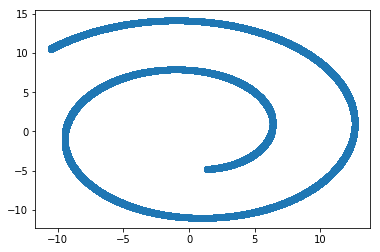

In [3]:
data_X = np.array([mat['X_data'].T[:,0],mat['X_data'].T[:,1]]).T
data_Y = np.array(mat['Y_data'][0])

fig =plt.figure()
ax = fig.add_subplot(111)
ax.scatter(mat['X_data'].T[:,0],mat['X_data'].T[:,1])


## Using PCA, reduce to 1 dimension

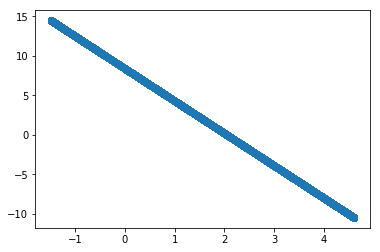

In [4]:
pca6 = PCA(n_components = 1)
lower_dimensional_data = pca6.fit_transform(data_X)
n_components6 = len(pca6.explained_variance_ratio_)
approximation6 = pca6.inverse_transform(lower_dimensional_data)
fig =plt.figure()
ax = fig.add_subplot(111)
ax.scatter(approximation6[:,0],approximation6[:,1])

In [5]:
loss = np.sum((approximation6 - data_X)**2)/data_X.shape[0]
print('PCA loss:', loss)

PCA loss: 50.07133676869117


## Trainning an autoencoder for 360 epoch, try to reconstruct the swiss roll

In [6]:
import os

import torch
import torchvision
from torch import nn
import torch.utils.data as utils
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

# if not os.path.exists('./mlp_img'):
#     os.mkdir('./mlp_img')


def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

pretrain = False
num_epochs = 10
batch_size = 512
learning_rate = 1e-3

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


tensor_x = torch.from_numpy(data_X) # transform to torch tensors
tensor_y =torch.from_numpy(data_Y)

my_dataset = utils.TensorDataset(tensor_x,tensor_y) # create your datset
train_dataloader = utils.DataLoader(my_dataset,batch_size = batch_size,shuffle = True) # create your dataloader
test_dataloader = utils.DataLoader(my_dataset,batch_size = 20000,shuffle = True) # create your dataloader


Error in all data:epoch [1/10], loss:61.1635


/anaconda3/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Error in all data:epoch [2/10], loss:36.7727
Error in all data:epoch [3/10], loss:29.0048
Error in all data:epoch [4/10], loss:25.9492
Error in all data:epoch [5/10], loss:24.2939
Error in all data:epoch [6/10], loss:19.2133
Error in all data:epoch [7/10], loss:12.8571
Error in all data:epoch [8/10], loss:8.5389
Error in all data:epoch [9/10], loss:7.4316
Error in all data:epoch [10/10], loss:5.2077


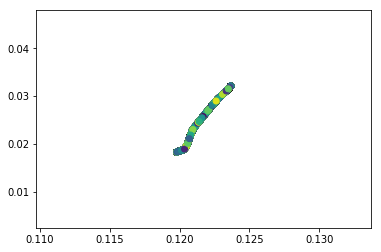

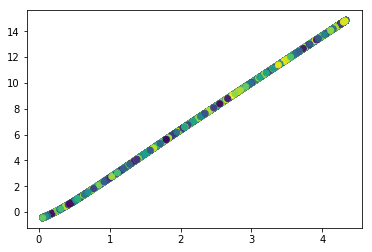

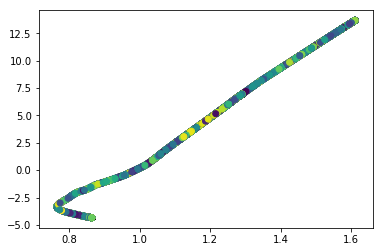

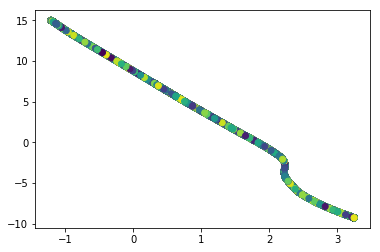

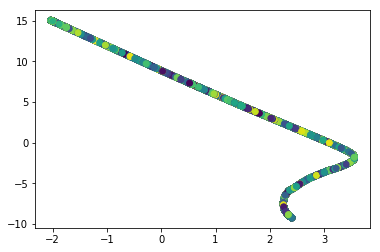

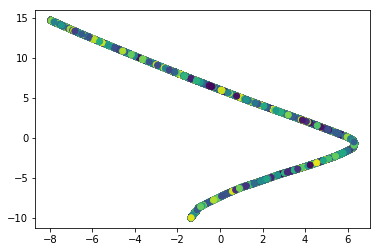

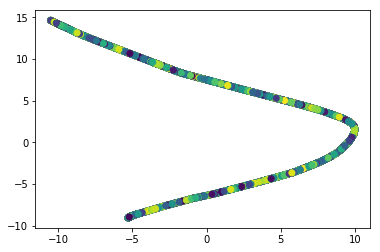

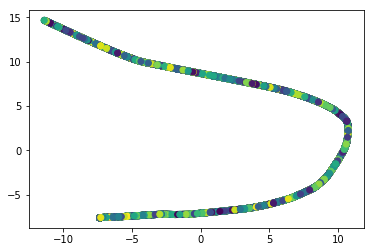

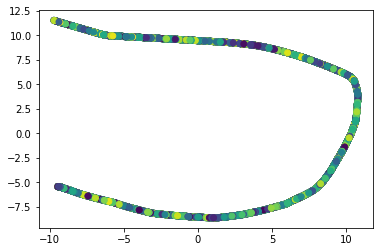

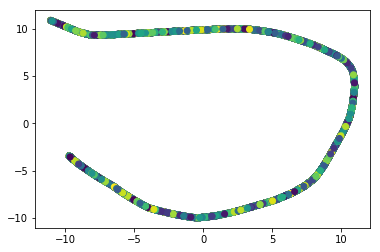

In [7]:

class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(True),
            nn.Linear(256, 64),
            nn.ReLU(True),
            nn.Linear(64, 32), 
            nn.ReLU(True), 
            nn.Linear(32, 8),
            nn.ReLU(True),
            nn.Linear(8, 1))
        self.decoder = nn.Sequential(
            nn.Linear(1, 8),
            nn.ReLU(True),
            nn.Linear(8, 32),
            nn.ReLU(True),
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, 256),
            nn.ReLU(True), 
            nn.Linear(256, 2))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



model = autoencoder()

if pretrain == True:
    model = torch.load('model/model1.pt')

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=1e-5)

for epoch in range(num_epochs):
    # ===================test&plot========================
    if epoch % 1 == 0:
        for data in test_dataloader:

            testimg, _ = data
            testimg = testimg.view(testimg.size(0), -1)
            testimg = Variable(testimg).float()
            testoutput = model(testimg.float())
            loss = criterion(testoutput, testimg)
            print('Error in all data:epoch [{}/{}], loss:{:.4f}'
              .format(epoch + 1, num_epochs, loss.data.item()))
            
            approximation = testoutput.detach().numpy()
            
            fig =plt.figure()
            plt.scatter(approximation[:,0],approximation[:,1],c = mat['Y_data'][0])
            fig.savefig('images/' + str(epoch)+'.png')

            break
    
    for data in train_dataloader:
        
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img).float()
        # ===================forward=====================
        output = model(img.float())
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
    # ===================log========================
    # print('epoch [{}/{}], loss:{:.4f}'
    #      .format(epoch + 1, num_epochs, loss.data.item()))
    
    # ===================save========================
    if epoch % 20 == 0:
        torch.save(model, 'model/model1.pt')

torch.save(model.state_dict(), './sim_autoencoder.pth')

## Convert all .png image in to a .gif

In [13]:
os.chdir('images')
images = []
filenames=sorted((fn for fn in os.listdir('.') if fn.endswith('.png')),key=lambda x: int(re.sub('[a-z.]', '', x)))
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('gif.gif', images,duration=0.05)

os.chdir(os.path.dirname(os.getcwd()))